# Imports

In [122]:
# Bibliotecas padrão
import numpy as np
import pandas as pd

# PySpark - Sessão
from pyspark.sql import SparkSession

# PySpark - Funções
from pyspark.sql.functions import (
    concat_ws,
    avg,
    col,
    count,
    lit,
    log,
    percentile_approx,
    sum as Fsum,
    udf,
    when,
    to_date,
    lpad,
)

# PySpark - Tipos
from pyspark.sql.types import IntegerType, StringType

# PySpark - Janela
from pyspark.sql.window import Window


✅ 2. Separar as proporções em dev (ref) e oot (compare)

Agora vamos pivotar para ter proportion_dev e proportion_oot em colunas separadas:

✅ 2. Separar as proporções em dev (ref) e oot (compare)

Agora vamos pivotar para ter proportion_dev e proportion_oot em colunas separadas:

# Simulando nosso dataset

Ótimo! Vamos construir juntos uma simulação com os seguintes critérios:

🎯 Objetivo:
	•	Simular dois modelos (modelo_a, modelo_b)
	•	Cada um com dados nos ambientes:
	•	DEV: 6 meses
	•	OOT: 3 meses
	•	PRD: 12 meses
	•	modelo_a permanece calibrado
	•	modelo_b vai descalibrando ao longo do tempo

⸻

📦 Etapas da simulação:
	1.	Gerar uma base com colunas: score, env, year, month, model
	2.	modelo_a: score estável em todos os ambientes
	3.	modelo_b: score muda ao longo do tempo (ex: média ou variância cresce em PRD)

⸻

🐍 Código de simulação (usando Pandas)

In [23]:
import pandas as pd
import numpy as np

def simulate_model_data(model_name, start_year=2023):
    """
    Simula scores e variável resposta para um modelo nos ambientes DEV, OOT e PRD.
    
    modelo_a: score calibrado e estável
    modelo_b: score descalibrando em PRD (aumenta média ao longo do tempo)
    """
    rows = []
    rng = np.random.default_rng(seed=42 if model_name == 'modelo_a' else 99)

    def generate_block(env, year, month, loc, size=1000):
        # Gera scores com média loc e desvio padrão 0.1
        scores = rng.normal(loc=loc, scale=0.1, size=size)
        scores = np.clip(scores, 0.01, 0.99)  # garantir intervalo válido [0, 1]
        vr = rng.binomial(1, p=scores)  # variável resposta: simula desfecho com base no score
        return pd.DataFrame({
            'model': model_name,
            'env': env,
            'year': year,
            'month': month,
            'score': scores,
            'vr': vr
        })

    # Ambiente DEV (6 meses estáveis)
    for month in range(1, 7):
        rows.append(generate_block('DEV', start_year, month, loc=0.5))

    # Ambiente OOT (3 meses)
    for month in range(7, 10):
        loc = 0.5 if model_name == 'modelo_a' else 0.55  # modelo_b levemente deslocado
        rows.append(generate_block('OOT', start_year, month, loc=loc))

    # Ambiente PRD (12 meses)
    for month in range(1, 13):
        year = start_year + 1
        loc = 0.5 if model_name == 'modelo_a' else 0.5 + 0.02 * month  # modelo_b descalibra gradualmente
        rows.append(generate_block('PRD', year, month, loc=loc))

    return pd.concat(rows, ignore_index=True)

# Gerar os dados simulados
df_a = simulate_model_data('modelo_a')
df_b = simulate_model_data('modelo_b')

# Unir os dois modelos em um único DataFrame
df = pd.concat([df_a, df_b], ignore_index=True)

# Visualizar primeiros registros
print(df.head())


      model  env  year  month     score  vr
0  modelo_a  DEV  2023      1  0.530472   0
1  modelo_a  DEV  2023      1  0.396002   0
2  modelo_a  DEV  2023      1  0.575045   1
3  modelo_a  DEV  2023      1  0.594056   1
4  modelo_a  DEV  2023      1  0.304896   0


🧪 Colunas do DataFrame final:

* model: "modelo_a" ou "modelo_b"
* env: ambiente (DEV, OOT, PRD)
* year: ano
* month: mês
* score: probabilidade estimada pelo modelo (entre 0 e 1)
* vr: variável resposta (0 ou 1), simulada com base no score

In [24]:
df

,model,env,year,month,score,vr
0,modelo_a,DEV,2023,1,0.530472,0
1,modelo_a,DEV,2023,1,0.396002,0
2,modelo_a,DEV,2023,1,0.575045,1
3,modelo_a,DEV,2023,1,0.594056,1
4,modelo_a,DEV,2023,1,0.304896,0
...,...,...,...,...,...,...
41995,modelo_b,PRD,2024,12,0.518542,1
41996,modelo_b,PRD,2024,12,0.733841,0
41997,modelo_b,PRD,2024,12,0.799363,1
41998,modelo_b,PRD,2024,12,0.708009,0




✅ Resultado

Temos um DataFrame com:
	•	2 modelos (modelo_a e modelo_b)
	•	Score gerado mês a mês em diferentes ambientes
	•	modelo_b vai ficando cada vez mais diferente de DEV no ambiente de produção

⸻

In [50]:
# Initialize Spark Session
spark = SparkSession.builder.appName("GroupByCustomFunction").getOrCreate()

spkdf = spark.createDataFrame(df)
spkdf.show(10)

+--------+---+----+-----+-------------------+---+
|   model|env|year|month|              score| vr|
+--------+---+----+-----+-------------------+---+
|modelo_a|DEV|2023|    1| 0.5304717079754432|  0|
|modelo_a|DEV|2023|    1| 0.3960015893759504|  0|
|modelo_a|DEV|2023|    1| 0.5750451195806457|  1|
|modelo_a|DEV|2023|    1| 0.5940564716391213|  1|
|modelo_a|DEV|2023|    1|0.30489648113461637|  0|
|modelo_a|DEV|2023|    1| 0.3697820493137682|  0|
|modelo_a|DEV|2023|    1| 0.5127840403167285|  0|
|modelo_a|DEV|2023|    1|0.46837574076564176|  1|
|modelo_a|DEV|2023|    1|0.49831988424957113|  1|
|modelo_a|DEV|2023|    1|  0.414695607242642|  0|
+--------+---+----+-----+-------------------+---+
only showing top 10 rows



----
# Agregação de dados por decis de score

✅ Objetivo detalhado

* 1.	Calcular os decis do score (por exemplo, 10 faixas de score) no ambiente dev.
* 2.	Depois, com esses cortes, desejamos calcular a taxa de 1’s (média de vr) dentro de cada faixa, incluindo os dados de outros ambientes (oot por exemplo).
* 3.	Queremos isso por modelo e ano_mes.

----

A solução ideal é evitar loops e trabalhar com funções nativas do Spark, especialmente usando percentile_approx, when, col, groupBy, e window.


✅ Solução eficiente (sem loop, distribuída)

1. Filtrar ambiente dev e calcular decis por modelo e ano_mes

In [145]:
spkdf.filter(
            (col("env") == "DEV") 
                &
            (col("month")==1)
            ).show()

+--------+---+----+-----+-------------------+---+
|   model|env|year|month|              score| vr|
+--------+---+----+-----+-------------------+---+
|modelo_a|DEV|2023|    1| 0.5304717079754432|  0|
|modelo_a|DEV|2023|    1| 0.3960015893759504|  0|
|modelo_a|DEV|2023|    1| 0.5750451195806457|  1|
|modelo_a|DEV|2023|    1| 0.5940564716391213|  1|
|modelo_a|DEV|2023|    1|0.30489648113461637|  0|
|modelo_a|DEV|2023|    1| 0.3697820493137682|  0|
|modelo_a|DEV|2023|    1| 0.5127840403167285|  0|
|modelo_a|DEV|2023|    1|0.46837574076564176|  1|
|modelo_a|DEV|2023|    1|0.49831988424957113|  1|
|modelo_a|DEV|2023|    1|  0.414695607242642|  0|
|modelo_a|DEV|2023|    1| 0.5879397974862829|  1|
|modelo_a|DEV|2023|    1| 0.5777791935428949|  1|
|modelo_a|DEV|2023|    1| 0.5066030697561216|  0|
|modelo_a|DEV|2023|    1| 0.6127241206968033|  0|
|modelo_a|DEV|2023|    1| 0.5467509342252046|  1|
|modelo_a|DEV|2023|    1| 0.4140707537116762|  1|
|modelo_a|DEV|2023|    1| 0.5368750784082499|  1|


In [51]:
# Número de faixas
n_bins = 10

# Calcular os decis no ambiente dev
decis_df = (
    spkdf.filter(col("env") == "DEV")\
      .groupBy("model")\
      .agg(percentile_approx("score", [i / n_bins for i in range(1, n_bins)], 10000).alias("cuts"))
)

decis_df.show()

+--------+--------------------+
|   model|                cuts|
+--------+--------------------+
|modelo_a|[0.37168521973963...|
|modelo_b|[0.36972121483852...|
+--------+--------------------+



2. Juntar os decis com os dados para classificar as faixas

Você pode criar uma UDF para mapear cada score à sua faixa com base nos cortes de decil:

In [54]:
def assign_decile(score, cuts):
    '''
    Description: Assigns a decile to a score. This is a simple function that assigns a score to a decile.
    Parameters:
        score: the score to be assigned to a decile
        cuts: the list of cutoffs for the deciles
    Returns:
        The decile number (1-10) that the score falls into.
    '''
    if cuts is None:
        return None
    for i, c in enumerate(cuts):
        if score <= c:
            return i + 1
    return len(cuts) + 1  # última faixa

assign_decile_udf = udf(assign_decile, IntegerType())

def label_decile(scores, cuts):
    '''
    Description: Assigns a decile to a score. This is a simple function that assigns a score to a decile.
    Parameters:
        scores: the scores to be assigned to a decile
        cuts: the list of cutoffs for the deciles
    Returns:
        The decile number (1-10) that the score falls into.
    '''
    
    if cuts is None:
        return None
    for i, c in enumerate(cuts):
        if scores <= c:
            if i==0:
                return f'<{c:.4f}'
            else:
                return f'{cuts[i-1]:.4f} - {c:.4f}'
    return f'>{c:.4f}'  # última faixa

label_decile_udf = udf(label_decile, StringType())

Agora junte os decis com os dados originais e aplique a UDF:


In [ ]:
# Juntar cortes com o DataFrame original
df_with_cuts = spkdf.join(decis_df, on=["model"], how="left")

# Aplicar a função para criar uma coluna de faixa de score
df_with_deciles = df_with_cuts\
    .withColumn("faixa_score", assign_decile_udf(col("score"), col("cuts")))\
    .withColumn("label_faixa_score", label_decile_udf(col("score"), col("cuts")))
df_with_deciles.filter(col('env') != 'DEV').orderBy(col("model"), col("year"), col("month"), col("score").desc()).show(10)

+--------+---+----+-----+------------------+---+--------------------+-----------+-----------------+
|   model|env|year|month|             score| vr|                cuts|faixa_score|label_faixa_score|
+--------+---+----+-----+------------------+---+--------------------+-----------+-----------------+
|modelo_a|OOT|2023|    7|0.8026651591695066|  1|[0.37168521973963...|         10|          >0.6289|
|modelo_a|OOT|2023|    7|0.7923643357604659|  0|[0.37168521973963...|         10|          >0.6289|
|modelo_a|OOT|2023|    7|0.7862263577284522|  1|[0.37168521973963...|         10|          >0.6289|
|modelo_a|OOT|2023|    7|0.7823117411267145|  1|[0.37168521973963...|         10|          >0.6289|
|modelo_a|OOT|2023|    7|0.7684376606796336|  1|[0.37168521973963...|         10|          >0.6289|
|modelo_a|OOT|2023|    7|0.7611076228409263|  1|[0.37168521973963...|         10|          >0.6289|
|modelo_a|OOT|2023|    7|0.7601974078158437|  0|[0.37168521973963...|         10|          >0.6289|


3. Calcular a taxa de 1’s (vr) por faixa de score

In [29]:
result_df = (
    df_with_deciles.groupBy("model", "year", "month", "env", "faixa_score")\
        .agg(avg("vr").alias("taxa_de_1s"))\
        .orderBy("model", "year", "month", "env", "faixa_score")
)
result_df.show(10)

+--------+----+-----+---+-----------+----------+
|   model|year|month|env|faixa_score|taxa_de_1s|
+--------+----+-----+---+-----------+----------+
|modelo_a|2023|    1|DEV|          1|      0.37|
|modelo_a|2023|    1|DEV|          2|      0.35|
|modelo_a|2023|    1|DEV|          3|      0.41|
|modelo_a|2023|    1|DEV|          4|      0.48|
|modelo_a|2023|    1|DEV|          5|      0.55|
|modelo_a|2023|    1|DEV|          6|       0.6|
|modelo_a|2023|    1|DEV|          7|      0.53|
|modelo_a|2023|    1|DEV|          8|      0.57|
|modelo_a|2023|    1|DEV|          9|      0.62|
|modelo_a|2023|    1|DEV|         10|      0.63|
+--------+----+-----+---+-----------+----------+
only showing top 10 rows



---
✅ Resultado

Você terá um DataFrame com:
	•	modelo
	•	ano_mes
	•	ambiente (dev, oot, etc.)
	•	faixa_score (1 a 10)
	•	taxa_de_1s (média de vr em cada faixa)

---

⚠️ Importante
	•	Essa abordagem é distribuída, ou seja, evita loop e union, aproveitando o Spark ao máximo.
	•	Se quiser incluir contagem de registros por faixa ou outras métricas, pode usar .agg(avg(...), count(...), ...).

---


# Calcular o psi


Agora vamos calcular o PSI (`Population Stability Index`) — uma métrica usada para comparar a distribuição de uma variável (geralmente score) entre dois conjuntos (ex: dev vs oot).

---

✅ Passo a passo para calcular o PSI

O PSI é calculado assim, para cada faixa de score:

$$\text{PSI} = \sum \left( (p_i - q_i) \cdot \ln\left(\frac{p_i}{q_i}\right) \right)$$

Onde:

*	p_i: proporção da faixa i no ambiente de referência (ex: dev)
*	q_i: proporção da mesma faixa no ambiente de comparação (ex: oot)

---

✅ Pré-requisitos

Como você já criou as faixas de score com base no ambiente dev e aplicou a classificação para outros ambientes, temos:

*	modelo, ano_mes, ambiente, faixa_score, vr
*	Vamos agora contar a proporção de registros em cada faixa por ambiente e calcular o PSI entre dev e oot.

---

✅ 1. Calcular a proporção em cada faixa e ambiente

In [72]:
df_with_deciles.show(5)

+--------+---+----+-----+-------------------+---+--------------------+-----------+-----------------+
|   model|env|year|month|              score| vr|                cuts|faixa_score|label_faixa_score|
+--------+---+----+-----+-------------------+---+--------------------+-----------+-----------------+
|modelo_a|DEV|2023|    1| 0.5304717079754432|  0|[0.37168521973963...|          7|  0.5243 - 0.5514|
|modelo_a|DEV|2023|    1| 0.3960015893759504|  0|[0.37168521973963...|          2|  0.3717 - 0.4165|
|modelo_a|DEV|2023|    1| 0.5750451195806457|  1|[0.37168521973963...|          8|  0.5514 - 0.5826|
|modelo_a|DEV|2023|    1| 0.5940564716391213|  1|[0.37168521973963...|          9|  0.5826 - 0.6289|
|modelo_a|DEV|2023|    1|0.30489648113461637|  0|[0.37168521973963...|          1|          <0.3717|
+--------+---+----+-----+-------------------+---+--------------------+-----------+-----------------+
only showing top 5 rows



In [33]:
df_with_deciles.groupby('env').count().show()

+---+-----+
|env|count|
+---+-----+
|PRD|24000|
|OOT| 6000|
|DEV|12000|
+---+-----+



In [81]:
# Agrupar por modelo, ambiente e faixa_score
df_referencia_proporcao_faixa = df_with_deciles \
    .filter(col('env') == 'DEV') \
    .groupBy("model", "env", "faixa_score") \
    .agg(count("*").alias("count"))

# Definir a janela para somar os counts por modelo e ambiente
window_spec = Window.partitionBy("model", "env")

# Adicionar a coluna de proporção
df_referencia_proporcao_faixa = df_referencia_proporcao_faixa \
    .withColumn("total", Fsum("count").over(window_spec)) \
    .withColumn("proporcao_ref", col("count") / col("total")) \
    .orderBy("model", "env", "faixa_score")

df_referencia_proporcao_faixa.show()

+--------+---+-----------+-----+-----+-------------------+
|   model|env|faixa_score|count|total|      proporcao_ref|
+--------+---+-----------+-----+-----+-------------------+
|modelo_a|DEV|          1|  599| 6000|0.09983333333333333|
|modelo_a|DEV|          2|  600| 6000|                0.1|
|modelo_a|DEV|          3|  600| 6000|                0.1|
|modelo_a|DEV|          4|  600| 6000|                0.1|
|modelo_a|DEV|          5|  600| 6000|                0.1|
|modelo_a|DEV|          6|  600| 6000|                0.1|
|modelo_a|DEV|          7|  600| 6000|                0.1|
|modelo_a|DEV|          8|  600| 6000|                0.1|
|modelo_a|DEV|          9|  600| 6000|                0.1|
|modelo_a|DEV|         10|  601| 6000|0.10016666666666667|
|modelo_b|DEV|          1|  599| 6000|0.09983333333333333|
|modelo_b|DEV|          2|  600| 6000|                0.1|
|modelo_b|DEV|          3|  600| 6000|                0.1|
|modelo_b|DEV|          4|  600| 6000|                0.

In [108]:
# Agrupar por modelo, ambiente e faixa_score
df_out_dev_proporcao_faixa = df_with_deciles \
    .filter(col('env') != 'DEV') \
    .groupBy("model", "env", "faixa_score", "year", "month") \
    .agg(count("*").alias("count"))

# Definir a janela para somar os counts por modelo e ambiente
window_spec = Window.partitionBy("model", "env")

# Adicionar a coluna de proporção
df_out_dev_proporcao_faixa = df_out_dev_proporcao_faixa \
    .withColumn("total", Fsum("count").over(window_spec)) \
    .withColumn("proporcao", col("count") / col("total")) \
    .orderBy("model", "env", "faixa_score")


# adicionar a coluna de proporção referencia
df_out_dev_proporcao_faixa = df_out_dev_proporcao_faixa.join(
    df_referencia_proporcao_faixa.select("model", "faixa_score", "proporcao_ref"), 
    on=["model", "faixa_score"],
    how="left"
) 
df_out_dev_proporcao_faixa.show()

+--------+-----------+---+----+-----+-----+-----+--------------------+-------------------+
|   model|faixa_score|env|year|month|count|total|           proporcao|      proporcao_ref|
+--------+-----------+---+----+-----+-----+-----+--------------------+-------------------+
|modelo_a|          8|OOT|2023|    9|   88| 3000|0.029333333333333333|                0.1|
|modelo_a|          1|OOT|2023|    8|   91| 3000|0.030333333333333334|0.09983333333333333|
|modelo_a|         10|OOT|2023|    8|  115| 3000| 0.03833333333333333|0.10016666666666667|
|modelo_a|          9|OOT|2023|    8|   95| 3000| 0.03166666666666667|                0.1|
|modelo_a|          3|OOT|2023|    8|  105| 3000|               0.035|                0.1|
|modelo_a|          8|OOT|2023|    7|   92| 3000|0.030666666666666665|                0.1|
|modelo_a|          4|OOT|2023|    9|  113| 3000| 0.03766666666666667|                0.1|
|modelo_a|          2|OOT|2023|    7|   99| 3000|               0.033|                0.1|

In [139]:
# Substituindo valores zero por 1e-6 para evitar divisão por zero ou log de zero
safe_ref = when(col("proporcao_ref") == 0, lit(1e-6)).otherwise(col("proporcao_ref"))
safe_prop = when(col("proporcao") == 0, lit(1e-6)).otherwise(col("proporcao"))

# Criando uma nova coluna com o cálculo do PSI
df_out_dev_proporcao_faixa = df_out_dev_proporcao_faixa.withColumn(
    "psi_component",
    (safe_ref - safe_prop) * log(safe_ref / safe_prop)
)

# Agora sim, agregando com sum
df_psi = df_out_dev_proporcao_faixa.groupBy("model", "env", "year", "month").agg(
    Fsum("psi_component").alias("psi")
)

df_psi.show()

+--------+---+----+-----+------------------+
|   model|env|year|month|               psi|
+--------+---+----+-----+------------------+
|modelo_a|OOT|2023|    9|0.7427351317680397|
|modelo_a|OOT|2023|    8|0.7418317669982292|
|modelo_a|OOT|2023|    7|0.7411746085766344|
|modelo_a|PRD|2024|    8|2.2863989970524616|
|modelo_a|PRD|2024|   11|2.2826349321577593|
|modelo_a|PRD|2024|    7|2.2848506530967305|
|modelo_a|PRD|2024|    9| 2.280632157811023|
|modelo_a|PRD|2024|    2|2.2815298596299436|
|modelo_a|PRD|2024|    4| 2.282056092096412|
|modelo_a|PRD|2024|   12| 2.284845373663066|
|modelo_a|PRD|2024|    3| 2.283451765544504|
|modelo_a|PRD|2024|    6|2.2813021212913602|
|modelo_a|PRD|2024|   10|2.2822363227401037|
|modelo_a|PRD|2024|    1|  2.28613901352983|
|modelo_a|PRD|2024|    5|2.2844089284259086|
|modelo_b|OOT|2023|    9|0.9163204953811663|
|modelo_b|OOT|2023|    7|0.9161549215798626|
|modelo_b|OOT|2023|    8|0.9210761997216893|
|modelo_b|PRD|2024|   12|3.2987251218389066|
|modelo_b|

In [126]:
df_psi = df_psi.withColumn(
    "data",
    to_date(
        concat_ws("-", 
            col("year").cast("string"), 
            lpad(col("month").cast("string"), 2, "0"), 
            lit("01")
        ), 
        "yyyy-MM-dd"
    )
)
df_psi.show()

+--------+---+----+-----+------------------+----------+
|   model|env|year|month|               psi|      data|
+--------+---+----+-----+------------------+----------+
|modelo_a|OOT|2023|    9|0.7427351317680397|2023-09-01|
|modelo_a|OOT|2023|    8|0.7418317669982292|2023-08-01|
|modelo_a|OOT|2023|    7|0.7411746085766344|2023-07-01|
|modelo_a|PRD|2024|    8|2.2863989970524616|2024-08-01|
|modelo_a|PRD|2024|   11|2.2826349321577593|2024-11-01|
|modelo_a|PRD|2024|    7|2.2848506530967305|2024-07-01|
|modelo_a|PRD|2024|    9| 2.280632157811023|2024-09-01|
|modelo_a|PRD|2024|    2|2.2815298596299436|2024-02-01|
|modelo_a|PRD|2024|    4| 2.282056092096412|2024-04-01|
|modelo_a|PRD|2024|   12| 2.284845373663066|2024-12-01|
|modelo_a|PRD|2024|    3| 2.283451765544504|2024-03-01|
|modelo_a|PRD|2024|    6|2.2813021212913602|2024-06-01|
|modelo_a|PRD|2024|   10|2.2822363227401037|2024-10-01|
|modelo_a|PRD|2024|    1|  2.28613901352983|2024-01-01|
|modelo_a|PRD|2024|    5|2.2844089284259086|2024

In [111]:
import seaborn as sns
from matplotlib import pyplot as plt

ValueError: Could not interpret value `data` for `x`. An entry with this name does not appear in `data`.

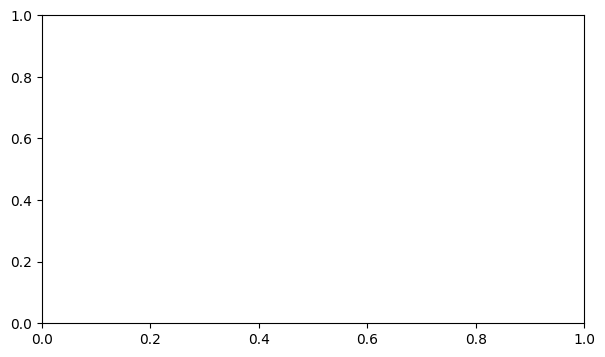

In [141]:

fig, ax = plt.subplots(figsize=(7, 4))

# Plot principal
sns.lineplot(
    x='data', y='psi',
    hue='model', style='env',
    data=df_psi.toPandas(), dashes=False,
    markers=True, markeredgecolor='w'
)

plt.axhline(0.1, color="orange", linestyle="--", label="limite moderado")
plt.axhline(0.25, color="red", linestyle="--", label="limite crítico")
plt.title("Evolução do PSI - modelo_b")
plt.xlabel("Data")
plt.ylabel("PSI")


plt.xticks(rotation=90)


# remover upper and right axis and set on the grid
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
plt.tight_layout()

plt.show()

In [ ]:
# Bibliotecas padrão
import numpy as np
import pandas as pd

# PySpark
from pyspark.sql import SparkSession
from pyspark.sql.functions import (
    col, count, lit, log, percentile_approx, sum as Fsum,
    when, to_date, concat_ws, lpad
)
from pyspark.sql.types import IntegerType, StringType
from pyspark.sql.window import Window
from pyspark.sql.functions import udf

from matplotlib import pyplot as plt
import seaborn as sns

# ======================
# Simulação dos dados
# ======================
def simulate_model_data(model_name: str, start_year: int = 2023) -> pd.DataFrame:
    """Simula scores e variável resposta para diferentes ambientes."""
    rng = np.random.default_rng(seed=42 if model_name == 'modelo_a' else 99)

    def generate_block(env, year, month, loc, size=1000):
        scores = np.clip(rng.normal(loc=loc, scale=0.1, size=size), 0.01, 0.99)
        vr = rng.binomial(1, p=scores)
        return pd.DataFrame({
            'model': model_name, 'env': env, 'year': year, 'month': month,
            'score': scores, 'vr': vr
        })

    data = []
    for month in range(1, 7):
        data.append(generate_block('DEV', start_year, month, 0.5))

    for month in range(7, 13):
        loc = 0.5 if model_name == 'modelo_a' else 0.55
        data.append(generate_block('OOT', start_year, month, loc))

    for month in range(1, 13):
        year = start_year + 1
        loc = 0.5 if model_name == 'modelo_a' else 0.5 + 0.02 * month
        data.append(generate_block('PRD', year, month, loc))

    return pd.concat(data, ignore_index=True)

# Dados simulados
df = pd.concat([simulate_model_data('modelo_a'), simulate_model_data('modelo_b')], ignore_index=True)

# ======================
# Spark Session
# ======================
spark = SparkSession.builder.appName("PSIAnalysis").getOrCreate()
spkdf = spark.createDataFrame(df)

# ======================
# Cálculo dos decis
# ======================
n_bins = 10
cutoffs = (
    spkdf.filter(col("env") == "DEV")
        .groupBy("model")
        .agg(percentile_approx("score", [i / n_bins for i in range(1, n_bins)], 10000).alias("cuts"))
)

# ======================
# Funções de faixa
# ======================
@udf(IntegerType())
def assign_decile(score, cuts):
    if cuts is None:
        return None
    for i, c in enumerate(cuts):
        if score <= c:
            return i + 1
    return len(cuts) + 1

@udf(StringType())
def label_decile(score, cuts):
    if cuts is None:
        return None
    for i, c in enumerate(cuts):
        if score <= c:
            return f"<{c:.4f}" if i == 0 else f"{cuts[i-1]:.4f} - {c:.4f}"
    return f">{cuts[-1]:.4f}"

# ======================
# Aplicação das faixas
# ======================
df_with_cuts = spkdf.join(cutoffs, on="model", how="left")
df_with_deciles = df_with_cuts.withColumn("faixa_score", assign_decile(col("score"), col("cuts"))) \
                            .withColumn("label_faixa_score", label_decile(col("score"), col("cuts")))

# ======================
# Proporção de referência (DEV)
# ======================
ref_counts = (df_with_deciles.filter(col("env") == "DEV")
                            .groupBy("model", "env", "faixa_score")
                            .agg(count("*").alias("count")))

window_ref = Window.partitionBy("model", "env")
df_ref_prop = ref_counts.withColumn("total", Fsum("count").over(window_ref)) \
                        .withColumn("proporcao_ref", col("count") / col("total"))

# ======================
# Proporção fora do DEV (OOT e PRD)
# ======================
out_counts = (df_with_deciles.filter(col("env") != "DEV")
                            .groupBy("model", "env", "faixa_score", "year", "month")
                            .agg(count("*").alias("count")))

window_out = Window.partitionBy("model", "env")
df_out_prop = out_counts.withColumn("total", Fsum("count").over(window_out)) \
                        .withColumn("proporcao", col("count") / col("total"))

# ======================
# Cálculo do PSI
# ======================
df_psi_calc = df_out_prop.join(
    df_ref_prop.select("model", "faixa_score", "proporcao_ref"),
    on=["model", "faixa_score"], how="left"
)

safe_ref = when(col("proporcao_ref") == 0, lit(1e-6)).otherwise(col("proporcao_ref"))
safe_prop = when(col("proporcao") == 0, lit(1e-6)).otherwise(col("proporcao"))

df_psi_calc = df_psi_calc.withColumn(
    "psi_component", (safe_ref - safe_prop) * log(safe_ref / safe_prop)
)

df_psi = df_psi_calc.groupBy("model", "env", "year", "month") \
                    .agg(Fsum("psi_component").alias("psi")) \
                    .withColumn("data", to_date(concat_ws("-", col("year"), lpad(col("month"), 2, "0"), lit("01")), "yyyy-MM-dd"))

# ======================
# Resultado final
# ======================
df_psi.orderBy("model", "data").show(10, truncate=False)

df_psi.show()


fig, ax = plt.subplots(figsize=(7, 4))

# Plot principal
sns.lineplot(
    x='data', y='psi',
    hue='model', style='env',
    data=df_psi.toPandas(), dashes=False,
    markers=True, markeredgecolor='w'
)

plt.axhline(0.1, color="orange", linestyle="--", label="limite moderado")
plt.axhline(0.25, color="red", linestyle="--", label="limite crítico")
plt.title("Evolução do PSI")
plt.xlabel("Data")
plt.ylabel("PSI")


plt.xticks(rotation=90)


# remover upper and right axis and set on the grid
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.grid(True, linestyle='-', linewidth=0.2)
ax.xaxis.grid(True, linestyle='-', linewidth=0.2)
plt.tight_layout()
plt.legend()
plt.show()
